## Dataset Description
In this competition we are segmenting organs cells in images. The training annotations are provided as RLE-encoded masks, and the images are in 16-bit grayscale PNG format.

Each case in this competition is represented by multiple sets of scan slices (each set is identified by the day the scan took place). Some cases are split by time (early days are in train, later days are in test) while some cases are split by case - the entirety of the case is in train or test. The goal of this competition is to be able to generalize to both partially and wholly unseen cases.

Note that, in this case, the test set is entirely unseen. It is roughly 50 cases, with a varying number of days and slices, as seen in the training set.

## How does an entirely hidden test set work?
The test set in this competition is only available when your code is submitted. The sample_submission.csv provided in the public set is an empty placeholder that shows the required submission format; you should perform your modeling, cross-validation, etc., using the training set, and write code to process a non-empty sample submission. It will contain rows with id, class and predicted columns as described in the Evaluation page.

When you submit your notebook, your code will be run against the non-hidden test set, which has the same folder format (<case>/<case_day>/<scans>) as the training data.

## Files
* train.csv - IDs and masks for all training objects.
* sample_submission.csv - a sample submission file in the correct format
* train - a folder of case/day folders, each containing slice images for a particular case on a given day.
Note that the image filenames include 4 numbers (ex. 276_276_1.63_1.63.png). These four numbers are slice width / height (integers in pixels) and width/height pixel spacing (floating points in mm). The first two defines the resolution of the slide. The last two record the physical size of each pixel.

Physical pixel thickness in superior-inferior direction is 3mm.

Columns
* id - unique identifier for object
* class - the predicted class for the object
* segmentation - RLE-encoded pixels for the identified object

In [1]:
from PIL import Image
from IPython.display import display
from torch.utils.data import Dataset, DataLoader
from skimage.transform import resize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import glob
import os
import time
import re

from common import DATASET_FOLDER, DATASET_CSV

files = []
for dirname, _, filenames in os.walk(DATASET_FOLDER + "train/"):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))


print("n files:", len(files))
print(files[:5])

n files: 38496
['/mnt/HDD/Download/uw-madison-gi-tract-image-segmentation/train/case130/case130_day0/scans/slice_0001_266_266_1.50_1.50.png', '/mnt/HDD/Download/uw-madison-gi-tract-image-segmentation/train/case130/case130_day0/scans/slice_0002_266_266_1.50_1.50.png', '/mnt/HDD/Download/uw-madison-gi-tract-image-segmentation/train/case130/case130_day0/scans/slice_0003_266_266_1.50_1.50.png', '/mnt/HDD/Download/uw-madison-gi-tract-image-segmentation/train/case130/case130_day0/scans/slice_0004_266_266_1.50_1.50.png', '/mnt/HDD/Download/uw-madison-gi-tract-image-segmentation/train/case130/case130_day0/scans/slice_0005_266_266_1.50_1.50.png']


In [2]:
input_paths_metadata = []
pattern = r".*(case\d+)_(day\d+)/scans/(slice_\d+)_(\d+)_(\d+)_(\d+\.\d+)_(\d+.\d+).png$"
for f in files:
    m = re.match(pattern, f)
    if m:
        input_paths_metadata.append(
            dict(
                case=m.group(1),
                day=m.group(2),
                slice=m.group(3),
                resolution_w=int(m.group(4)),
                resolution_h=int(m.group(5)),
                pixel_w=float(m.group(6)),
                pixel_h=float(m.group(7)),
                path=f,
            )
        )
    else:
        print("no match!")
input_paths_metadata = pd.DataFrame(input_paths_metadata)
input_paths_metadata

,case,day,slice,resolution_w,resolution_h,pixel_w,pixel_h,path
0,case130,day0,slice_0001,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...
1,case130,day0,slice_0002,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...
2,case130,day0,slice_0003,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...
3,case130,day0,slice_0004,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...
4,case130,day0,slice_0005,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...
...,...,...,...,...,...,...,...,...
38491,case92,day0,slice_0140,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...
38492,case92,day0,slice_0141,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...
38493,case92,day0,slice_0142,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...
38494,case92,day0,slice_0143,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...


In [3]:
df = pd.read_csv(DATASET_CSV, index_col=0)
id_split = pd.DataFrame(df["id"].str.split("_", n=2).tolist(), columns=["case", "day", "slice"])
df = df.join(id_split)
df = pd.merge(df, input_paths_metadata, how="inner", on=["case", "day", "slice"])
df

,id,class,segmentation,split,case,day,slice,resolution_w,resolution_h,pixel_w,pixel_h,path
0,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,test,case123,day20,slice_0065,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...
1,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...,train,case123,day20,slice_0066,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...
2,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...,train,case123,day20,slice_0067,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...
3,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...,test,case123,day20,slice_0068,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...
4,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...,train,case123,day20,slice_0069,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...
...,...,...,...,...,...,...,...,...,...,...,...,...
33908,case30_day0_slice_0135,small_bowel,22540 1 22804 5 23069 7 23334 10 23600 11 2386...,train,case30,day0,slice_0135,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...
33909,case30_day0_slice_0136,large_bowel,18746 7 19009 23 19038 7 19273 44 19537 49 198...,test,case30,day0,slice_0136,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...
33910,case30_day0_slice_0136,small_bowel,23079 1 23343 6 23608 9 23874 11 24139 13 2440...,test,case30,day0,slice_0136,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...
33911,case30_day0_slice_0137,large_bowel,18746 2 19010 8 19040 3 19274 25 19302 12 1953...,train,case30,day0,slice_0137,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...


In [4]:
# https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask2rle(img: np.ndarray):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    """
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)


def rle2mask(mask_rle: str, shape: tuple[int, int] = (266, 266)):
    """
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background

    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [5]:
segmentation_mask = df.apply(lambda r: rle2mask(r["segmentation"], (r["resolution_h"], r["resolution_w"])), axis=1)
df = df.join(segmentation_mask.rename("segmentation_mask"))
df

,id,class,segmentation,split,case,day,slice,resolution_w,resolution_h,pixel_w,pixel_h,path,segmentation_mask
0,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,test,case123,day20,slice_0065,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...,train,case123,day20,slice_0066,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...,train,case123,day20,slice_0067,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...,test,case123,day20,slice_0068,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...,train,case123,day20,slice_0069,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33908,case30_day0_slice_0135,small_bowel,22540 1 22804 5 23069 7 23334 10 23600 11 2386...,train,case30,day0,slice_0135,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
33909,case30_day0_slice_0136,large_bowel,18746 7 19009 23 19038 7 19273 44 19537 49 198...,test,case30,day0,slice_0136,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
33910,case30_day0_slice_0136,small_bowel,23079 1 23343 6 23608 9 23874 11 24139 13 2440...,test,case30,day0,slice_0136,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
33911,case30_day0_slice_0137,large_bowel,18746 2 19010 8 19040 3 19274 25 19302 12 1953...,train,case30,day0,slice_0137,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [6]:
# need to resize all images to same resolution, therefore also the segmentation masks
df[["resolution_w", "resolution_h"]].value_counts()

resolution_w  resolution_h
266           266             22328
360           310              9911
276           276              1557
234           234               117
Name: count, dtype: int64

case54_day32_slice_0063


,id,class,segmentation,split,case,day,slice,resolution_w,resolution_h,pixel_w,pixel_h,path,segmentation_mask
29086,case54_day32_slice_0063,large_bowel,21985 20 22248 25 22513 27 22779 28 23045 29 2...,train,case54,day32,slice_0063,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
29087,case54_day32_slice_0063,small_bowel,28094 5 28359 8 28625 10 28636 5 28890 19 2915...,train,case54,day32,slice_0063,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
29088,case54_day32_slice_0063,stomach,22488 4 22752 8 23016 11 23281 13 23547 14 238...,train,case54,day32,slice_0063,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


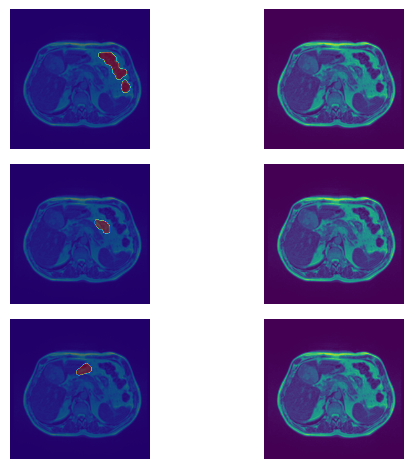

In [7]:
print(
    random_id := df["id"]
    .value_counts()
    .to_frame()
    .reset_index()
    .query("count == 3")["id"]
    .sample(1)
    .iloc[0]
)
random_case = df.query("id == @random_id")
display(random_case)

plt.figure()
# large bowel plots
large_bowel = random_case.query("`class` == 'large_bowel'")[["path", "segmentation_mask"]].iloc[0]
image_array = np.array(Image.open(large_bowel["path"]))
segmentation_mask = large_bowel["segmentation_mask"]
plt.subplot(321)
plt.imshow(image_array)
plt.imshow(segmentation_mask, alpha=0.5, cmap="jet")
plt.axis("off")
plt.subplot(322)
plt.imshow(image_array)
plt.axis("off")
# small bowel plots
small_bowel = random_case.query("`class` == 'small_bowel'")[["path", "segmentation_mask"]].iloc[0]
image_array = np.array(Image.open(small_bowel["path"]))
segmentation_mask = small_bowel["segmentation_mask"]
plt.subplot(323)
plt.imshow(image_array)
plt.imshow(segmentation_mask, alpha=0.5, cmap="jet")
plt.axis("off")
plt.subplot(324)
plt.imshow(image_array)
plt.axis("off")
# stomach plots
stomach = random_case.query("`class` == 'stomach'")[["path", "segmentation_mask"]].iloc[0]
image_array = np.array(Image.open(stomach["path"]))
segmentation_mask = stomach["segmentation_mask"]
plt.subplot(325)
plt.imshow(image_array)
plt.imshow(segmentation_mask, alpha=0.5, cmap="jet")
plt.axis("off")
plt.subplot(326)
plt.imshow(image_array)
plt.axis("off")

plt.tight_layout()
plt.show()

In [8]:
df.head()

,id,class,segmentation,split,case,day,slice,resolution_w,resolution_h,pixel_w,pixel_h,path,segmentation_mask
0,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,test,case123,day20,slice_0065,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...,train,case123,day20,slice_0066,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...,train,case123,day20,slice_0067,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...,test,case123,day20,slice_0068,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...,train,case123,day20,slice_0069,266,266,1.5,1.5,/mnt/HDD/Download/uw-madison-gi-tract-image-se...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


images must have same shape

In [9]:
from common import TENSORS_FOLDER

In [10]:
def reshape(image: Image.Image, mask_arr: np.ndarray, shape: tuple[int, int] = (128, 128)):
    image_reshaped = image.resize(shape)
    image_arr = np.array(image_reshaped)
    image_tensor = torch.from_numpy(image_arr).float()
    image_tensor = image_tensor.unsqueeze(0)  # add gray scale channel as first dim
    mask_arr = resize(mask_arr, shape, mode="constant")
    mask_arr = (mask_arr > 0).astype(np.float32)
    mask_tensor = torch.from_numpy(mask_arr).float()
    mask_tensor = mask_tensor.unsqueeze(0)
    return image_tensor, mask_tensor


def extract_data(row: pd.Series):
    image = Image.open(row["path"])
    mask = row["segmentation_mask"]
    image_tensor, mask_tensor = reshape(image, mask)
    return image_tensor, mask_tensor


# for i, x in df.iterrows():
#     unique_name = x["id"] + "_" + x["class"]
#     image_tensor, mask_tensor = extract_data(x)
#     subfolder = "train/" if x["split"] == "train" else "test/"
#     path = TENSORS_FOLDER + subfolder + unique_name + "_img.pt"
#     torch.save(image_tensor, path)
#     path = TENSORS_FOLDER + subfolder + unique_name + "_msk.pt"
#     torch.save(mask_tensor, path)

In [11]:
(device := torch.device("cuda" if torch.cuda.is_available() else "cpu"))

device(type='cuda')

In [12]:
import torch.multiprocessing as mp

# mp.set_start_method("spawn", force=True)


class SegmentationDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        x = df.iloc[index]
        image_tensor, mask_tensor = extract_data(x)
        return image_tensor.to(device), mask_tensor.to(device)


batch_size = 16
# num_workers = 8

train_dataset = SegmentationDataset(df[df["split"] == "train"])
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = SegmentationDataset(df[df["split"] == "test"])
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Accessing a sample
train_dataset[0]

(tensor([[[ 0., 12.,  9.,  ...,  0.,  0.,  0.],
          [ 1.,  1., 11.,  ...,  0.,  0.,  0.],
          [ 9.,  3., 15.,  ...,  0.,  2.,  0.],
          ...,
          [ 0.,  7., 17.,  ..., 13.,  7.,  1.],
          [-1.,  6., 17.,  ...,  8.,  5., -1.],
          [ 0.,  1.,  9.,  ...,  5.,  1.,  0.]]], device='cuda:0'),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'))

Feature batch shape: torch.Size([16, 1, 128, 128])
Labels batch shape: torch.Size([16, 1, 128, 128])


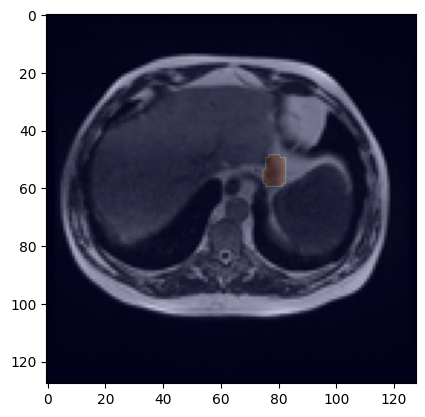

In [13]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
train_features = train_features.to("cpu")
train_labels = train_labels.to("cpu")
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
msk = train_labels[0].squeeze()
plt.imshow(img, cmap="gray")
plt.imshow(msk, cmap="jet", alpha=0.2)
plt.show()

In [14]:
# Define single convolutional block
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
    )


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        # default gray scale
        super(UNet, self).__init__()
        # Contracting path
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Deepest layer
        self.middle = conv_block(512, 1024)
        # Expanding path
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)
        # Output layer
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Contracting path
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        middle = self.middle(self.pool(enc4))
        # Expanding path
        dec4 = self.dec4(torch.cat([self.upconv4(middle), enc4], 1))
        dec3 = self.dec3(torch.cat([self.upconv3(dec4), enc3], 1))
        dec2 = self.dec2(torch.cat([self.upconv2(dec3), enc2], 1))
        dec1 = self.dec1(torch.cat([self.upconv1(dec2), enc1], 1))
        return self.out_conv(dec1)


In [15]:
model = UNet().to(device)
criterion = nn.MSELoss()  # TODO implement problem specific criterion
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    for inputs, targets in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Forward Pass
        outputs = model(inputs)
        # Calculate the loss
        loss = criterion(outputs, targets)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluation on validation and test datasets
model.eval()
with torch.no_grad():
    #     TODO create validation set
    #     for inputs, targets in validation_dataloader:  # Replace with your validation data
    # Perform evaluation and calculate metrics

    for inputs, targets in test_dataloader:
        # Perform evaluation and calculate metrics
        #         TODO evaluate
        pass

# Save the trained model
torch.save(model.state_dict(), "model.pth")

# Load a pre-trained model (optional)
loaded_model = UNet()
loaded_model.load_state_dict(torch.load("model.pth"))
loaded_model.eval()

# Fine-tuning (optional): Modify architecture or retrain specific layers

/mnt/HDD/python-envs/torch-venv/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [0/10], Loss: 0.0349
